<a href="https://colab.research.google.com/github/paulodreher/data_science/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install silence_tensorflow

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.0.2-cp36-none-any.whl size=3016 sha256=38c21ca576fe60a6db218aed032142fb5a1d57ca3af18ca3dd95d897abccfb25
  Stored in directory: /root/.cache/pip/wheels/2d/d0/dc/9b7d928602436b3732838d315e8e31bcea93b4fb67c047b53c
Successfully built silence-tensorflow


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
from keras.models import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications import MobileNet,InceptionResNetV2,InceptionV3
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import seaborn as sns
import zipfile
import json
import os
import h5py
from warnings import simplefilter
simplefilter(action='ignore')
import silence_tensorflow
import tensorflow as tf

Using TensorFlow backend.


# Settings

#Creating Data Frame

In [ ]:
archive = zipfile.ZipFile('/content/drive/My Drive/Pos/Machine Learning II/trabalho 3/celeba-dataset.zip')

In [ ]:
data = pd.read_csv(archive.open('list_attr_celeba.csv','r'), delimiter=',')
data.replace(to_replace=-1, value=0, inplace=True)

In [ ]:
data_labels = pd.read_csv(archive.open('list_eval_partition.csv','r'), delimiter=',')

In [ ]:
data_frame = pd.merge(data, data_labels, on='image_id')

In [ ]:
train_df = data_frame[data_frame.partition == 0]
train_df = train_df.loc[:, train_df.columns != 'partition']

valid_df = data_frame[data_frame.partition == 1]
valid_df = valid_df.loc[:, valid_df.columns != 'partition']

In [ ]:
train_columns = train_df.loc[:, train_df.columns != 'image_id']
valid_columns = valid_df.loc[:, valid_df.columns != 'image_id']

train_columns = train_columns[:0].columns.to_list()
valid_columns = valid_columns[:0].columns.to_list()

#Creating Images Folder

In [ ]:
def create_data_folders():
  if not os.path.isdir('train_data'):
    os.makedirs('train_data')

  if not os.path.isdir('validate_data'):
    os.makedirs('validate_data')

  if not os.path.isdir('test_data'):
    os.makedirs('test_data')

In [ ]:
def make_data_structured(archive):
  create_data_folders()

  for data_position in range(data_frame.shape[0]):
    if data_frame.iloc[data_position].partition == 0:
      archive.extract(zipfile.ZipFile.namelist(archive)[data_position], path='/content/train_data')
    elif data_frame.iloc[data_position].partition == 1:
      archive.extract(zipfile.ZipFile.namelist(archive)[data_position], path='/content/validate_data')
    else:
      archive.extract(zipfile.ZipFile.namelist(archive)[data_position], path='/content/test_data')

#Unzipping Images

In [ ]:
!unzip -qq '/content/drive/My Drive/train_data.zip' -d .

In [ ]:
!unzip -qq '/content/drive/My Drive/validate_data.zip' -d .

In [ ]:
!unzip -qq '/content/drive/My Drive/test_data.zip' -d .

#Setting Model

In [ ]:
inc_model = InceptionV3(weights=None, include_top=True, input_shape=(218,178,3))
model = inc_model.get_layer('avg_pool').output
predictions = Dense(40, activation='sigmoid')(model)
model = Model(inputs=inc_model.input, outputs=predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 218, 178, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 108, 88, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 108, 88, 32)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 108, 88, 32)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

Callbacks

In [ ]:
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/Pos/Machine Learning II/trabalho 3/weights_best.hdf5', verbose=1, save_best_only=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=3)

In [ ]:
cb_list = [checkpointer, early_stopping]

#Generating Images

First Image

In [ ]:
def reshape_img(image):
  image = img_to_array(load_img(image))/255
  return image.reshape((1,) + image.shape)

In [ ]:
first_image = zipfile.ZipFile.namelist(archive)[0]
first_image = archive.extract(first_image,'.')

In [ ]:
data_frame.loc[0][train_columns]

5_o_Clock_Shadow       0
Arched_Eyebrows        1
Attractive             1
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             1
Bushy_Eyebrows         0
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           1
High_Cheekbones        1
Male                   0
Mouth_Slightly_Open    1
Mustache               0
Narrow_Eyes            0
No_Beard               1
Oval_Face              0
Pale_Skin              0
Pointy_Nose            1
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                1
Straight_Hair          1
Wavy_Hair              0
Wearing_Earrings       1
Wearing_Hat            0
Wearing_Lipstick       1
Wearing_Necklace       0
Wearing_Necktie        0
Young                  1


Before ImageDataGenerator

Before modifications:


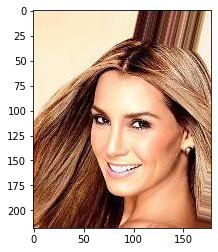

In [ ]:
print('Before modifications:')
first_image = load_img(first_image)
plt.grid(False)
plt.imshow(first_image)
plt.show()

After ImageDataGenerator

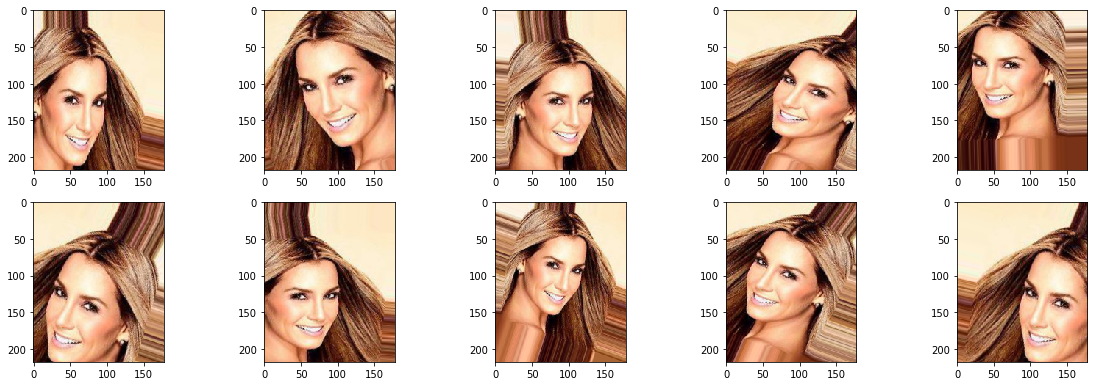

In [ ]:
image_reshaped = reshape_img('/content/img_align_celeba/img_align_celeba/000001.jpg')
image_generator = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

plt.figure(figsize=(20,10))
i = 0

for batch in image_generator.flow(image_reshaped, batch_size=1):
    plt.subplot(3,5,i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(218,178, 3))

    if i==9:
        break
    i = i+1

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='/content/content/train_data/img_align_celeba/img_align_celeba/',
        x_col='image_id',
        y_col=train_columns,
        target_size=(218, 178),
        batch_size=64,
        class_mode='raw')

Found 162770 validated image filenames.


In [ ]:
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory='/content/content/validate_data/img_align_celeba/img_align_celeba/',
        x_col='image_id',
        y_col=valid_columns,
        target_size=(218, 178),
        batch_size=64,
        class_mode='raw')

Found 19867 validated image filenames.


In [ ]:
history = model.fit_generator(
        train_generator,
        epochs= 10,
        validation_data = validation_generator,
        callbacks = cb_list,
        verbose=2)

model.save('/content/drive/My Drive/Pos/Machine Learning II/trabalho 3/image_classification.h5')

Epoch 1/10
 - 2531s - loss: 0.2737 - acc: 0.8798 - val_loss: 0.5990 - val_acc: 0.8030

Epoch 00001: val_loss improved from inf to 0.59901, saving model to /content/drive/My Drive/Pos/Machine Learning II/trabalho 3/weights_best.hdf5
Epoch 2/10
 - 2493s - loss: 0.2250 - acc: 0.9006 - val_loss: 0.6453 - val_acc: 0.7906

Epoch 00002: val_loss did not improve from 0.59901
Epoch 3/10
 - 2483s - loss: 0.2135 - acc: 0.9055 - val_loss: 0.6597 - val_acc: 0.8030

Epoch 00003: val_loss did not improve from 0.59901
Epoch 4/10
 - 2481s - loss: 0.2068 - acc: 0.9084 - val_loss: 0.5781 - val_acc: 0.8030

Epoch 00004: val_loss improved from 0.59901 to 0.57806, saving model to /content/drive/My Drive/Pos/Machine Learning II/trabalho 3/weights_best.hdf5
Epoch 5/10
 - 2476s - loss: 0.2020 - acc: 0.9106 - val_loss: 0.5328 - val_acc: 0.8030

Epoch 00005: val_loss improved from 0.57806 to 0.53285, saving model to /content/drive/My Drive/Pos/Machine Learning II/trabalho 3/weights_best.hdf5
Epoch 6/10
 - 2484s 